In [68]:
import numpy as np
import matplotlib.pyplot as plt
from data_logger.readrawdata import phpfina_feed
import pickle
import pandas as pd

emonCMS feeds:

    1 t1
    5 temperatureA
    6 humidityA
    7 temperatureB
    8 external temperatureB
    9 humidityB

In [69]:
df = phpfina_feed(8, data_path='data_logger/phpfina/')
df = df.resample('10min').mean()
df.columns = ['extB', ]

In [70]:
#df.resample('10min').count()

In [71]:
df1 = phpfina_feed(7, data_path='data_logger//phpfina/')
df1 = df1.resample('10min').mean()
df1.columns = ['intB', ]

In [72]:
df = df.merge(df1, left_index=True, right_index=True )

In [73]:
weather_data_path = './weather_api/data/mars_2020-03-17_2951days.pickle'

with open(weather_data_path, 'rb') as f:
    weatherdata = pickle.load(f)
    
weatherdata = weatherdata.resample('10min').interpolate()
weatherdata = pd.DataFrame(weatherdata)
weatherdata.index = weatherdata.index.tz_convert(None)

In [74]:
weatherdata.columns

Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'icon',
       'ozone', 'precipIntensity', 'precipProbability', 'precipType',
       'pressure', 'summary', 'temperature', 'uvIndex', 'visibility',
       'windBearing', 'windGust', 'windSpeed'],
      dtype='object')

In [75]:
weatherT = weatherdata['temperature']

In [76]:
df2 = df.merge( weatherT, left_index=True, right_index=True )

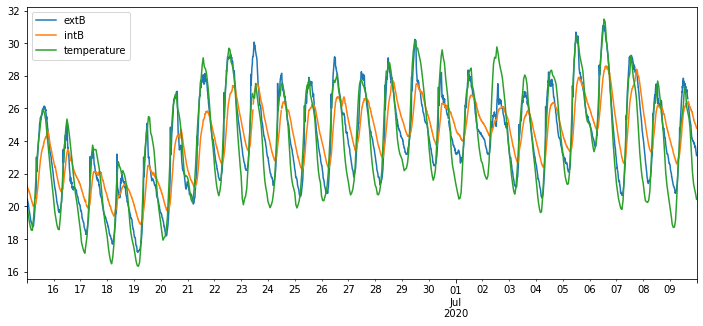

In [77]:
range_start, range_end = '2020-06-15', '2020-07-10'
time_range = (df2.index > range_start)&(df2.index < range_end)
df2[time_range].plot(figsize=(12, 5));

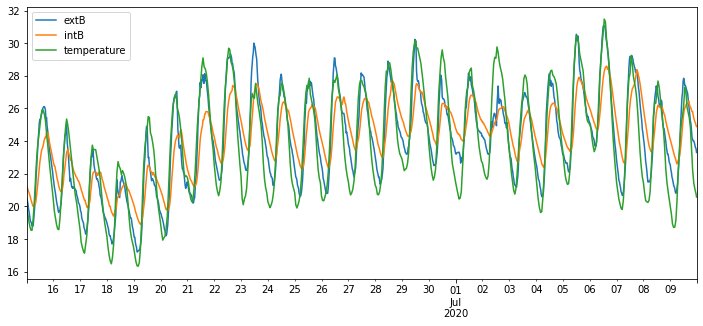

In [62]:
df30 = df2.resample('30min').interpolate()
dt = 0.5
time_range = (df30.index > range_start)&(df30.index < range_end)
df30[time_range].plot(figsize=(12, 5));

In [63]:
%load_ext autoreload
%autoreload 2
from pythsolver import solve_model
from scipy.optimize import curve_fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
time_index = df30[time_range].index
time = time_index.astype(int)*1e6

In [65]:
T_ext = df30['temperature'][time_range].to_numpy()
T_int = df30['intB'][time_range].to_numpy()

In [66]:
M1 = 1.0
T01 = T_int[0]

def solve_2R2C(params):
    M2, k1, k2, T02 = params
    
    nodes = [('int', M1, T01), # name, mass, T0
             ('wall', M2, T02)]

    sources = {'ext':T_ext}

    internal_links = [('int', 'wall', k2), ]
    external_links = [('int', 'ext',  k1),  ] # ext. second

    T = solve_model(nodes,
                    internal_links,
                    external_links,
                    sources,
                    dt)
    return T

def residuals_2R2C(x, *params):
    return solve_2R2C(params)[0, :]

# optimisation
labels = ['M2', 'k1', 'k2', 'T02']
p0 = [37, 10.0024, .2, 30]

popt, pcov = curve_fit(residuals_2R2C, time, T_int, p0=p0)
print('  '.join([f'{n}={p:.3f}' for n, p in zip(labels, popt)]))

# solve
T_theo = solve_2R2C(popt)
T_int_theo = T_theo[0, :]
T_wall_theo = T_theo[1, :]
R = T_int_theo - T_int

#print('k/M:', popt[1]/M1)
print('mean square residuals:', np.mean(R**2))

M2=2.220  k1=0.195  k2=0.154  T02=23.485
mean square residuals: 0.5703441996032159


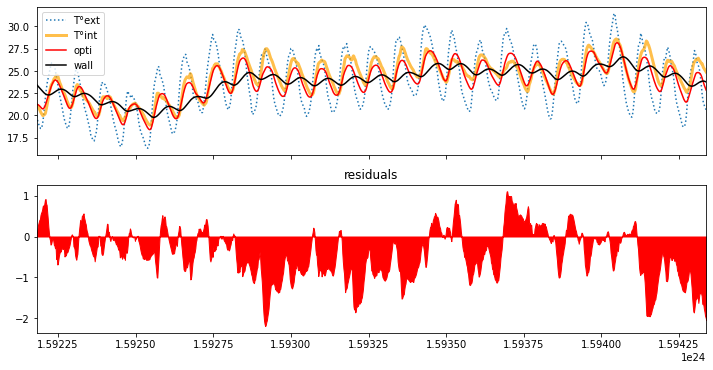

In [78]:
# Graphs
t_min_max = [np.min(time), np.max(time)]
#t_min_max = [200, 300]

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax1.plot(time, T_ext, ':', label='T°ext')
ax1.plot(time, T_int, '-', label='T°int', color='orange', linewidth=3, alpha=0.7)
ax1.plot(time, T_int_theo, label='opti', color='red')
ax1.plot(time, T_wall_theo, label='wall', color='black')
ax1.legend()
ax1.set_xlim(t_min_max);

# Residuals
ax2.fill_between(time, R, color='r');
ax2.set_title('residuals');
ax2.set_xlim(t_min_max);